In [2]:
import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn.neighbors import DistanceMetric
from math import radians
import folium
import geopandas as gpd
from shapely.geometry import Point
from scipy.spatial import cKDTree
from shapely.geometry import Point
from shapely.ops import nearest_points

# Junho


 Faltam os dias 3, 4, 5, 6, 12, 19, 26, 27

In [3]:
junho = pd.read_csv('/Users/guilistocco/Documents/TCC 2 - Ônibus/BancoDados/Dados brutos/passengers_junho.csv',
                    index_col= 'Unnamed: 0')

    #  Sao 214k linhas

In [4]:
junho

,device_id,timestampI,timestampF,MAC,RSSI,channel,latitudeI,longitudeI,latitudeF,longitudeF,cnt_pckg,id,duration
0,617.0,1622529842,1622529920,40:06:a0:5b:8c:b2,-45,11,-22.827145,-47.061214,-22.829490,-47.060281,40,0,78
1,617.0,1622529842,1622529920,0c:ef:af:d3:00:36,-65,11,-22.827145,-47.061214,-22.829490,-47.060281,15,1,78
2,617.0,1622529847,1622529875,24:fd:0d:bd:91:49,-67,6,-22.826890,-47.061367,-22.826994,-47.061368,3,2,28
3,617.0,1622529850,1622529850,0e:ec:8d:d0:6d:0d,-90,7,-22.826730,-47.061454,-22.826730,-47.061454,2,3,0
4,617.0,1622529856,1622529856,0a:cc:27:40:31:3c,-87,4,-22.826406,-47.061626,-22.826406,-47.061626,2,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
214541,NaN,1625079190,1625079190,22:ae:9f:77:09:55,-85,1,-22.816560,-47.072811,-22.816560,-47.072811,1,524,0
214542,NaN,1625079193,1625079196,50:92:b9:3b:a7:2a,-91,11,-22.816561,-47.072812,-22.816566,-47.072808,3,525,3
214543,NaN,1625079121,1625079121,ae:30:5e:57:df:56,-88,6,-22.816467,-47.072852,-22.816467,-47.072852,1,512,0
214544,NaN,1625079196,1625079196,28:16:7f:bc:c4:42,-93,6,-22.816566,-47.072808,-22.816566,-47.072808,1,526,0



## Preparacao dos dados

In [5]:
junho.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214546 entries, 0 to 214545
Data columns (total 13 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   device_id   106336 non-null  float64
 1   timestampI  214546 non-null  int64  
 2   timestampF  214546 non-null  int64  
 3   MAC         214546 non-null  object 
 4   RSSI        214546 non-null  int64  
 5   channel     214546 non-null  int64  
 6   latitudeI   214546 non-null  float64
 7   longitudeI  214546 non-null  float64
 8   latitudeF   214546 non-null  float64
 9   longitudeF  214546 non-null  float64
 10  cnt_pckg    214546 non-null  int64  
 11  id          214546 non-null  int64  
 12  duration    214546 non-null  int64  
dtypes: float64(5), int64(7), object(1)
memory usage: 22.9+ MB


In [6]:
## Tranforma timestamp em datas

junho['dataInicio'] = pd.to_datetime(junho['timestampI'], unit='s')
junho['dataFim'] = pd.to_datetime(junho['timestampF'], unit='s')

In [7]:
junho = junho[['MAC','latitudeI', 'longitudeI', 'latitudeF', 'longitudeF', 'cnt_pckg', 'duration', 'dataInicio', 'dataFim']]

In [8]:
## Cria a coluna com o dia de cada ping para os agrupamentos

junho['day'] = junho.dataInicio.dt.day

/var/folders/21/6bbwtzhx0js126xjwqnzpzzc0000gn/T/ipykernel_37969/1329112363.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  junho['day'] = junho.dataInicio.dt.day


In [9]:
junho.drop(index = junho[ junho.dataInicio.dt.day  !=  junho.dataFim.dt.day ].index , inplace = True)
junho.reset_index(drop = True)

/var/folders/21/6bbwtzhx0js126xjwqnzpzzc0000gn/T/ipykernel_37969/997527236.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  junho.drop(index = junho[ junho.dataInicio.dt.day  !=  junho.dataFim.dt.day ].index , inplace = True)


,MAC,latitudeI,longitudeI,latitudeF,longitudeF,cnt_pckg,duration,dataInicio,dataFim,day
0,40:06:a0:5b:8c:b2,-22.827145,-47.061214,-22.829490,-47.060281,40,78,2021-06-01 06:44:02,2021-06-01 06:45:20,1
1,0c:ef:af:d3:00:36,-22.827145,-47.061214,-22.829490,-47.060281,15,78,2021-06-01 06:44:02,2021-06-01 06:45:20,1
2,24:fd:0d:bd:91:49,-22.826890,-47.061367,-22.826994,-47.061368,3,28,2021-06-01 06:44:07,2021-06-01 06:44:35,1
3,0e:ec:8d:d0:6d:0d,-22.826730,-47.061454,-22.826730,-47.061454,2,0,2021-06-01 06:44:10,2021-06-01 06:44:10,1
4,0a:cc:27:40:31:3c,-22.826406,-47.061626,-22.826406,-47.061626,2,0,2021-06-01 06:44:16,2021-06-01 06:44:16,1
...,...,...,...,...,...,...,...,...,...,...
214087,22:ae:9f:77:09:55,-22.816560,-47.072811,-22.816560,-47.072811,1,0,2021-06-30 18:53:10,2021-06-30 18:53:10,30
214088,50:92:b9:3b:a7:2a,-22.816561,-47.072812,-22.816566,-47.072808,3,3,2021-06-30 18:53:13,2021-06-30 18:53:16,30
214089,ae:30:5e:57:df:56,-22.816467,-47.072852,-22.816467,-47.072852,1,0,2021-06-30 18:52:01,2021-06-30 18:52:01,30
214090,28:16:7f:bc:c4:42,-22.816566,-47.072808,-22.816566,-47.072808,1,0,2021-06-30 18:53:16,2021-06-30 18:53:16,30


In [10]:
## Cria coluna de ID para cada um dos MACS para facilitar identificacao

MACs_unicos = junho.MAC.unique()

temp = defaultdict(lambda: len(temp))
device_id = [temp[ele] for ele in MACs_unicos]

res = dict(zip(MACs_unicos, device_id))

junho['device_id'] = junho['MAC'].map(res)
junho

/var/folders/21/6bbwtzhx0js126xjwqnzpzzc0000gn/T/ipykernel_37969/48684942.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  junho['device_id'] = junho['MAC'].map(res)


,MAC,latitudeI,longitudeI,latitudeF,longitudeF,cnt_pckg,duration,dataInicio,dataFim,day,device_id
0,40:06:a0:5b:8c:b2,-22.827145,-47.061214,-22.829490,-47.060281,40,78,2021-06-01 06:44:02,2021-06-01 06:45:20,1,0
1,0c:ef:af:d3:00:36,-22.827145,-47.061214,-22.829490,-47.060281,15,78,2021-06-01 06:44:02,2021-06-01 06:45:20,1,1
2,24:fd:0d:bd:91:49,-22.826890,-47.061367,-22.826994,-47.061368,3,28,2021-06-01 06:44:07,2021-06-01 06:44:35,1,2
3,0e:ec:8d:d0:6d:0d,-22.826730,-47.061454,-22.826730,-47.061454,2,0,2021-06-01 06:44:10,2021-06-01 06:44:10,1,3
4,0a:cc:27:40:31:3c,-22.826406,-47.061626,-22.826406,-47.061626,2,0,2021-06-01 06:44:16,2021-06-01 06:44:16,1,4
...,...,...,...,...,...,...,...,...,...,...,...
214541,22:ae:9f:77:09:55,-22.816560,-47.072811,-22.816560,-47.072811,1,0,2021-06-30 18:53:10,2021-06-30 18:53:10,30,75860
214542,50:92:b9:3b:a7:2a,-22.816561,-47.072812,-22.816566,-47.072808,3,3,2021-06-30 18:53:13,2021-06-30 18:53:16,30,11060
214543,ae:30:5e:57:df:56,-22.816467,-47.072852,-22.816467,-47.072852,1,0,2021-06-30 18:52:01,2021-06-30 18:52:01,30,75854
214544,28:16:7f:bc:c4:42,-22.816566,-47.072808,-22.816566,-47.072808,1,0,2021-06-30 18:53:16,2021-06-30 18:53:16,30,68270


In [11]:
## Adiciona sequence para identificar dentro de um dia de qual a o numero da conexao atual (em uma lista ordenada)

junho.sort_values(by= ['device_id', 'dataInicio'], inplace = True)

junho['sequence'] = junho.groupby(['device_id', 'day']).cumcount()+1

junho.reset_index(drop = True, inplace = True)

junho

/var/folders/21/6bbwtzhx0js126xjwqnzpzzc0000gn/T/ipykernel_37969/2411379021.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  junho.sort_values(by= ['device_id', 'dataInicio'], inplace = True)
/var/folders/21/6bbwtzhx0js126xjwqnzpzzc0000gn/T/ipykernel_37969/2411379021.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  junho['sequence'] = junho.groupby(['device_id', 'day']).cumcount()+1


,MAC,latitudeI,longitudeI,latitudeF,longitudeF,cnt_pckg,duration,dataInicio,dataFim,day,device_id,sequence
0,40:06:a0:5b:8c:b2,-22.827145,-47.061214,-22.829490,-47.060281,40,78,2021-06-01 06:44:02,2021-06-01 06:45:20,1,0,1
1,40:06:a0:5b:8c:b2,-22.827686,-47.060967,-22.829620,-47.060375,18,37,2021-06-01 07:11:57,2021-06-01 07:12:34,1,0,2
2,40:06:a0:5b:8c:b2,-22.829639,-47.061859,-22.829639,-47.061859,1,0,2021-06-01 07:40:30,2021-06-01 07:40:30,1,0,3
3,40:06:a0:5b:8c:b2,-22.827037,-47.061207,-22.829638,-47.060359,53,78,2021-06-01 07:58:17,2021-06-01 07:59:35,1,0,4
4,40:06:a0:5b:8c:b2,-22.827689,-47.061027,-22.829669,-47.060578,20,37,2021-06-01 08:19:51,2021-06-01 08:20:28,1,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...
214087,fa:c2:29:96:e8:d4,-22.816555,-47.072823,-22.816555,-47.072823,1,0,2021-06-30 18:52:56,2021-06-30 18:52:56,30,75856,1
214088,38:80:df:de:83:78,-22.816558,-47.072823,-22.816554,-47.072819,13,3,2021-06-30 18:52:59,2021-06-30 18:53:02,30,75857,1
214089,b4:f7:a1:a1:ac:79,-22.816561,-47.072818,-22.816561,-47.072818,1,0,2021-06-30 18:53:06,2021-06-30 18:53:06,30,75858,1
214090,da:a1:19:97:4c:5d,-22.816560,-47.072812,-22.816560,-47.072812,2,0,2021-06-30 18:53:09,2021-06-30 18:53:09,30,75859,1


In [12]:
junho['periodo'] = None

junho.loc[junho['dataInicio'].dt.hour <= 12, 'periodo'] =  'Manha'
junho.loc[junho['dataInicio'].dt.hour > 12, 'periodo'] =  'Tarde'
junho

/var/folders/21/6bbwtzhx0js126xjwqnzpzzc0000gn/T/ipykernel_37969/2895883254.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  junho['periodo'] = None


,MAC,latitudeI,longitudeI,latitudeF,longitudeF,cnt_pckg,duration,dataInicio,dataFim,day,device_id,sequence,periodo
0,40:06:a0:5b:8c:b2,-22.827145,-47.061214,-22.829490,-47.060281,40,78,2021-06-01 06:44:02,2021-06-01 06:45:20,1,0,1,Manha
1,40:06:a0:5b:8c:b2,-22.827686,-47.060967,-22.829620,-47.060375,18,37,2021-06-01 07:11:57,2021-06-01 07:12:34,1,0,2,Manha
2,40:06:a0:5b:8c:b2,-22.829639,-47.061859,-22.829639,-47.061859,1,0,2021-06-01 07:40:30,2021-06-01 07:40:30,1,0,3,Manha
3,40:06:a0:5b:8c:b2,-22.827037,-47.061207,-22.829638,-47.060359,53,78,2021-06-01 07:58:17,2021-06-01 07:59:35,1,0,4,Manha
4,40:06:a0:5b:8c:b2,-22.827689,-47.061027,-22.829669,-47.060578,20,37,2021-06-01 08:19:51,2021-06-01 08:20:28,1,0,5,Manha
...,...,...,...,...,...,...,...,...,...,...,...,...,...
214087,fa:c2:29:96:e8:d4,-22.816555,-47.072823,-22.816555,-47.072823,1,0,2021-06-30 18:52:56,2021-06-30 18:52:56,30,75856,1,Tarde
214088,38:80:df:de:83:78,-22.816558,-47.072823,-22.816554,-47.072819,13,3,2021-06-30 18:52:59,2021-06-30 18:53:02,30,75857,1,Tarde
214089,b4:f7:a1:a1:ac:79,-22.816561,-47.072818,-22.816561,-47.072818,1,0,2021-06-30 18:53:06,2021-06-30 18:53:06,30,75858,1,Tarde
214090,da:a1:19:97:4c:5d,-22.816560,-47.072812,-22.816560,-47.072812,2,0,2021-06-30 18:53:09,2021-06-30 18:53:09,30,75859,1,Tarde


In [13]:

##### OUTDATED #####

## Criando coluna de duracao da conexao entre os pings



junho['duration(s)'] = (junho['dataFim'] - junho['dataInicio']).dt.total_seconds()

/var/folders/21/6bbwtzhx0js126xjwqnzpzzc0000gn/T/ipykernel_37969/357497754.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  junho['duration(s)'] = (junho['dataFim'] - junho['dataInicio']).dt.total_seconds()


In [14]:
## funcao de calculo de distancia entre o ponto de inicio e fim da conexao

def haversine_vectorize(lon1, lat1, lon2, lat2):
    # print(lon1, lat1, lon2, lat2)
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    newlon = lon2 - lon1
    newlat = lat2 - lat1

    haver_formula = np.sin(newlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(newlon/2.0)**2

    dist = 2 * np.arcsin(np.sqrt(haver_formula ))
    m = 6_371_000 * dist #6371 for distance in KM for miles use 3958
    return m

junho['distance(m)'] = junho.apply(lambda x : haversine_vectorize(x['longitudeI'], x['latitudeI'], x['longitudeF'], x['latitudeF']) * 1.2, axis = 1)


junho

/var/folders/21/6bbwtzhx0js126xjwqnzpzzc0000gn/T/ipykernel_37969/2923288923.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  junho['distance(m)'] = junho.apply(lambda x : haversine_vectorize(x['longitudeI'], x['latitudeI'], x['longitudeF'], x['latitudeF']) * 1.2, axis = 1)


,MAC,latitudeI,longitudeI,latitudeF,longitudeF,cnt_pckg,duration,dataInicio,dataFim,day,device_id,sequence,periodo,duration(s),distance(m)
0,40:06:a0:5b:8c:b2,-22.827145,-47.061214,-22.829490,-47.060281,40,78,2021-06-01 06:44:02,2021-06-01 06:45:20,1,0,1,Manha,78.0,333.068136
1,40:06:a0:5b:8c:b2,-22.827686,-47.060967,-22.829620,-47.060375,18,37,2021-06-01 07:11:57,2021-06-01 07:12:34,1,0,2,Manha,37.0,267.966298
2,40:06:a0:5b:8c:b2,-22.829639,-47.061859,-22.829639,-47.061859,1,0,2021-06-01 07:40:30,2021-06-01 07:40:30,1,0,3,Manha,0.0,0.000000
3,40:06:a0:5b:8c:b2,-22.827037,-47.061207,-22.829638,-47.060359,53,78,2021-06-01 07:58:17,2021-06-01 07:59:35,1,0,4,Manha,78.0,362.164440
4,40:06:a0:5b:8c:b2,-22.827689,-47.061027,-22.829669,-47.060578,20,37,2021-06-01 08:19:51,2021-06-01 08:20:28,1,0,5,Manha,37.0,269.738511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214087,fa:c2:29:96:e8:d4,-22.816555,-47.072823,-22.816555,-47.072823,1,0,2021-06-30 18:52:56,2021-06-30 18:52:56,30,75856,1,Tarde,0.0,0.000000
214088,38:80:df:de:83:78,-22.816558,-47.072823,-22.816554,-47.072819,13,3,2021-06-30 18:52:59,2021-06-30 18:53:02,30,75857,1,Tarde,3.0,0.725430
214089,b4:f7:a1:a1:ac:79,-22.816561,-47.072818,-22.816561,-47.072818,1,0,2021-06-30 18:53:06,2021-06-30 18:53:06,30,75858,1,Tarde,0.0,0.000000
214090,da:a1:19:97:4c:5d,-22.816560,-47.072812,-22.816560,-47.072812,2,0,2021-06-30 18:53:09,2021-06-30 18:53:09,30,75859,1,Tarde,0.0,0.000000


In [15]:
## Coluna de velocidade media para avalicao se os movimentos sao coerentes

# junho['velMed(km/h)'] = junho['distance(m)']/junho['duration(s)'] *3.6

# junho


In [16]:
# junho[['lat1', 'long1']] = junho[['latitudeF', 'longitudeF']].shift(1)

# junho['distance_lagged(m)'] = junho.apply(lambda x : haversine_vectorize(x['long1'], x['lat1'], x['longitudeI'], x['latitudeI']), axis = 1)

# junho

In [17]:
junho.loc[(junho['MAC'] == "40:06:a0:5b:8c:b2")   & (junho['day']== 1) ]

,MAC,latitudeI,longitudeI,latitudeF,longitudeF,cnt_pckg,duration,dataInicio,dataFim,day,device_id,sequence,periodo,duration(s),distance(m)
0,40:06:a0:5b:8c:b2,-22.827145,-47.061214,-22.829490,-47.060281,40,78,2021-06-01 06:44:02,2021-06-01 06:45:20,1,0,1,Manha,78.0,333.068136
1,40:06:a0:5b:8c:b2,-22.827686,-47.060967,-22.829620,-47.060375,18,37,2021-06-01 07:11:57,2021-06-01 07:12:34,1,0,2,Manha,37.0,267.966298
2,40:06:a0:5b:8c:b2,-22.829639,-47.061859,-22.829639,-47.061859,1,0,2021-06-01 07:40:30,2021-06-01 07:40:30,1,0,3,Manha,0.0,0.000000
3,40:06:a0:5b:8c:b2,-22.827037,-47.061207,-22.829638,-47.060359,53,78,2021-06-01 07:58:17,2021-06-01 07:59:35,1,0,4,Manha,78.0,362.164440
4,40:06:a0:5b:8c:b2,-22.827689,-47.061027,-22.829669,-47.060578,20,37,2021-06-01 08:19:51,2021-06-01 08:20:28,1,0,5,Manha,37.0,269.738511
5,40:06:a0:5b:8c:b2,-22.827116,-47.061166,-22.829648,-47.060414,38,78,2021-06-01 09:06:10,2021-06-01 09:07:28,1,0,6,Manha,78.0,350.063969
6,40:06:a0:5b:8c:b2,-22.827030,-47.061240,-22.829614,-47.060350,30,78,2021-06-01 11:10:03,2021-06-01 11:11:21,1,0,7,Manha,78.0,361.522224
7,40:06:a0:5b:8c:b2,-22.828242,-47.066670,-22.828242,-47.066670,1,0,2021-06-01 11:13:08,2021-06-01 11:13:08,1,0,8,Manha,0.0,0.000000
8,40:06:a0:5b:8c:b2,-22.827211,-47.061172,-22.829681,-47.060513,63,81,2021-06-01 11:57:21,2021-06-01 11:58:42,1,0,9,Manha,81.0,339.187065
9,40:06:a0:5b:8c:b2,-22.825315,-47.066428,-22.825315,-47.066428,1,0,2021-06-01 12:01:39,2021-06-01 12:01:39,1,0,10,Manha,0.0,0.000000


In [18]:
junho.loc[(junho['day']== 1) ]['MAC'].value_counts()

40:06:a0:5b:8c:b2    21
0c:ef:af:d3:00:36    17
84:18:3a:4a:d3:68    14
ec:fa:bc:1a:3a:b7    14
10:72:23:a9:1d:2f    14
                     ..
8e:69:a6:3d:dd:e0     1
d4:63:c6:d0:ef:65     1
00:0a:eb:26:11:8a     1
26:03:e0:4d:0f:34     1
90:73:5a:63:d8:14     1
Name: MAC, Length: 4637, dtype: int64

## Agrupamentio dos usuarios por dias contando numero de conexoes

Aqui pode haver mais coisas a se fazer

Como eh possivel ver no caso do dia=1 device=0
 - a data de inicio eh no dia 1, e a data fim eh no dia 2
 - isso nao acontece pra todos os devices, mas para os que acontecem pode ser retrabalhado

In [19]:
junho_group = junho.groupby(['day','device_id', 'periodo']).agg({
                                                        'dataInicio': 'min',
                                                        'dataFim':'max',
                                                        'sequence':'count',
                                                        'distance(m)':'sum'
                                                        ,'duration(s)':'sum'
})
# junho_group.loc[:,'distance(m)']  = junho_group['distance(m)'] + junho_group['distance_lagged(m)']
# junho_group.drop(labels = ['distance_lagged(m)'],inplace=True, axis = 1)

# junho_group['duration(s)'] = (junho_group['dataFim'] - junho_group['dataInicio']).dt.total_seconds()

junho_group

dataInicio             dataFim  sequence  \
day device_id periodo                                                     
1   0         Manha   2021-06-01 06:44:02 2021-06-01 12:34:31        11   
              Tarde   2021-06-01 13:11:24 2021-06-01 17:28:43        10   
    1         Manha   2021-06-01 06:44:02 2021-06-01 12:34:25         9   
              Tarde   2021-06-01 13:11:28 2021-06-01 17:05:21         8   
    2         Manha   2021-06-01 06:44:07 2021-06-01 12:33:53         6   
...                                   ...                 ...       ...   
30  75856     Tarde   2021-06-30 18:52:56 2021-06-30 18:52:56         1   
    75857     Tarde   2021-06-30 18:52:59 2021-06-30 18:53:02         1   
    75858     Tarde   2021-06-30 18:53:06 2021-06-30 18:53:06         1   
    75859     Tarde   2021-06-30 18:53:09 2021-06-30 18:53:09         1   
    75860     Tarde   2021-06-30 18:53:10 2021-06-30 18:53:10         1   

                       distance(m)  duration(s)  
day device_id periodo                            
1   0         Manha    2555.035204       1169.0  
              Tarde    3986.951935       3959.0  
    1         Manha    2372.188508       1105.0  
              Tarde    2046.926540       3183.0  
    2         Manha     390.572020        804.0  
...                            ...          ...  
30  75856     Tarde       0.000000          0.0  
    75857     Tarde       0.725430          3.0  
    75858     Tarde       0.000000          0.0  
    75859     Tarde       0.000000          0.0  
    75860     Tarde       0.000000          0.0  

[138389 rows x 5 columns]

#### Recuperando a primeira e ultima coordenada

 - Usando o usuario/MAC e o primeiro e ultimo momento em conexao
 - Buscar as coordenadas desses dispositivos nesse instante (inicial e final)
 - Comparar com a coordenada dos pontos de onibus para determinar qual o ponto de embarque do passageiro e ponto de desembarque

In [20]:


junho_coordenadas = junho_group.merge(junho[['day','device_id', 'periodo', 'dataInicio', 'latitudeI', 'longitudeI']],  
                                        right_on= ['day', 'device_id', 'periodo', 'dataInicio'], 
                                        left_on=  ['day','device_id',  'periodo','dataInicio']).merge(
                                            junho[['day','device_id', 'periodo','dataFim', 'latitudeF', 'longitudeF']],  
                                            right_on= ['day', 'device_id', 'periodo','dataFim'], 
                                            left_on=  ['day','device_id',  'periodo','dataFim'])


junho_coordenadas

,day,device_id,periodo,dataInicio,dataFim,sequence,distance(m),duration(s),latitudeI,longitudeI,latitudeF,longitudeF
0,1,0,Manha,2021-06-01 06:44:02,2021-06-01 12:34:31,11,2555.035204,1169.0,-22.827145,-47.061214,-22.829398,-47.060331
1,1,0,Tarde,2021-06-01 13:11:24,2021-06-01 17:28:43,10,3986.951935,3959.0,-22.826960,-47.061293,-22.816325,-47.072641
2,1,1,Manha,2021-06-01 06:44:02,2021-06-01 12:34:25,9,2372.188508,1105.0,-22.827145,-47.061214,-22.829112,-47.060477
3,1,1,Tarde,2021-06-01 13:11:28,2021-06-01 17:05:21,8,2046.926540,3183.0,-22.826777,-47.061416,-22.829708,-47.060686
4,1,2,Manha,2021-06-01 06:44:07,2021-06-01 12:33:53,6,390.572020,804.0,-22.826890,-47.061367,-22.827097,-47.061306
...,...,...,...,...,...,...,...,...,...,...,...,...
139198,30,75856,Tarde,2021-06-30 18:52:56,2021-06-30 18:52:56,1,0.000000,0.0,-22.816555,-47.072823,-22.816555,-47.072823
139199,30,75857,Tarde,2021-06-30 18:52:59,2021-06-30 18:53:02,1,0.725430,3.0,-22.816558,-47.072823,-22.816554,-47.072819
139200,30,75858,Tarde,2021-06-30 18:53:06,2021-06-30 18:53:06,1,0.000000,0.0,-22.816561,-47.072818,-22.816561,-47.072818
139201,30,75859,Tarde,2021-06-30 18:53:09,2021-06-30 18:53:09,1,0.000000,0.0,-22.816560,-47.072812,-22.816560,-47.072812


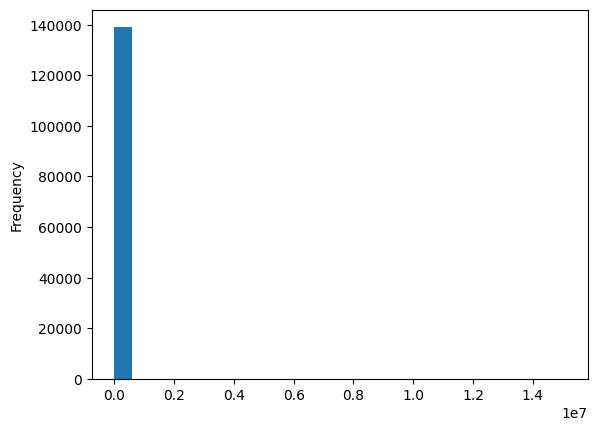

In [35]:
junho_coordenadas['distance(m)'].plot(kind='hist', bins = 25);

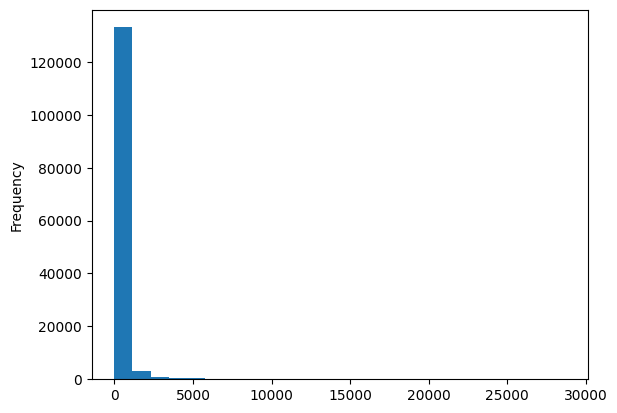

In [36]:
junho_coordenadas['duration(s)'].plot(kind='hist', bins = 25);

## Selecao de passageiros validos

#### Histograma Duration 
    - entre um minuto e uma hora de viagem
    - pelo menos 300m percorridos

Conclusao: Concentracao viagens de curta ducarao (ate 10 minutos)

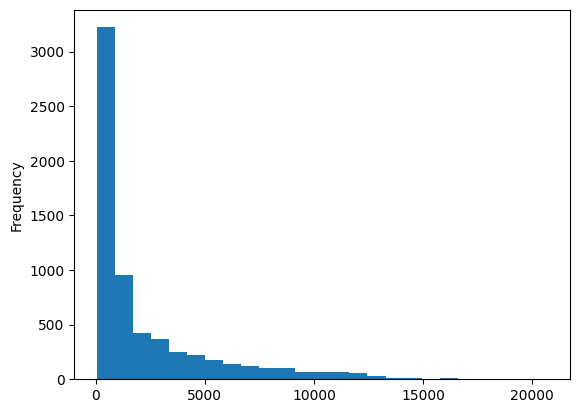

In [22]:

junho_coordenadas.loc[  ((  junho_coordenadas['duration(s)'] > 60   ) ) &
                        ((  junho_coordenadas['distance(m)'] > 300   )  ), 'duration(s)'].plot(kind='hist', bins = 25);

##### Casos para corte dos passageiros validos

- Ha casos em que a duracao conexao de um passageiro eh superior a 47000 segundos (12h)
    - isso ocorre para passageiros que usam a linha diariamente
    - assim a dataInicio ocorre no fim de um dia e a dataFim no inicio de outro
- Com isso deve-se faze rum corte para retirar essas anomalia

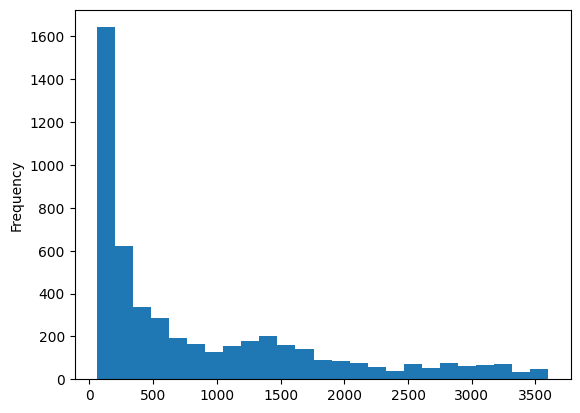

In [23]:
junho_coordenadas.loc[  ((  junho_coordenadas['duration(s)'] > 60   ) & (  junho_coordenadas['duration(s)'] < 3600   ) ) &
                        ((  junho_coordenadas['distance(m)'] > 300   )  ), 'duration(s)'].plot(kind='hist', bins = 25);

#### Histograma Distance 
    - entre um minuto e uma hora de viagem
    - pelo menos 300m percorridos

##### Conclusao: Absoluta concentracao viagens de curta ducarao (ate 10 minutos)

    - 95% percentil de viagens é de 2km
    - Sao 230 viagens com mais de 2km, razoavel retirar sujeira

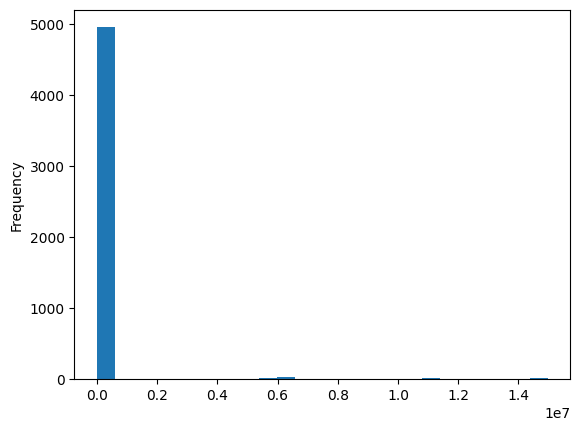

In [24]:

junho_coordenadas.loc[  ((  junho_coordenadas['duration(s)'] > 60   ) & (  junho_coordenadas['duration(s)'] < 3600   ) ) &
                        ((  junho_coordenadas['distance(m)'] > 300   )  ), 'distance(m)'].plot(kind='hist', bins = 25);

In [25]:

junho_coordenadas.loc[  ((  junho_coordenadas['duration(s)'] > 60   ) & (  junho_coordenadas['duration(s)'] < 3600   ) ) &
                        ((  junho_coordenadas['distance(m)'] > 300   )  ), 'distance(m)'].describe(percentiles=[ .25, .5, .75, .80, .85, .90, .95])
# sao 4030

count    5.049000e+03
mean     1.577321e+05
std      1.248878e+06
min      3.001354e+02
25%      4.351360e+02
50%      6.202075e+02
75%      9.857510e+02
80%      1.113287e+03
85%      1.300795e+03
90%      1.575693e+03
95%      2.105086e+03
max      1.497899e+07
Name: distance(m), dtype: float64

In [26]:

junho_coordenadas.loc[  ((  junho_coordenadas['duration(s)'] > 60   ) & (  junho_coordenadas['duration(s)'] < 3600   ) ) &
                        ((  junho_coordenadas['distance(m)'] > 2000   )  ) ]

,day,device_id,periodo,dataInicio,dataFim,sequence,distance(m),duration(s),latitudeI,longitudeI,latitudeF,longitudeF
0,1,0,Manha,2021-06-01 06:44:02,2021-06-01 12:34:31,11,2.555035e+03,1169.0,-22.827145,-47.061214,-22.829398,-47.060331
2,1,1,Manha,2021-06-01 06:44:02,2021-06-01 12:34:25,9,2.372189e+03,1105.0,-22.827145,-47.061214,-22.829112,-47.060477
3,1,1,Tarde,2021-06-01 13:11:28,2021-06-01 17:05:21,8,2.046927e+03,3183.0,-22.826777,-47.061416,-22.829708,-47.060686
25,1,14,Tarde,2021-06-01 13:07:53,2021-06-01 18:10:06,8,2.734360e+03,2607.0,-22.813319,-47.065397,-22.813783,-47.070272
63,1,39,Manha,2021-06-01 07:30:44,2021-06-01 11:33:27,2,1.488892e+07,1736.0,-22.816326,-47.072648,-22.815417,-47.072656
...,...,...,...,...,...,...,...,...,...,...,...,...
136390,30,10804,Manha,2021-06-30 07:35:25,2021-06-30 12:57:49,5,6.087544e+06,1570.0,-22.824826,-47.065397,-22.824955,-47.065593
136814,30,28281,Tarde,2021-06-30 14:28:15,2021-06-30 16:27:28,2,2.269308e+03,789.0,-22.816346,-47.072649,-22.821261,-47.067696
136948,30,43508,Tarde,2021-06-30 18:24:26,2021-06-30 18:29:19,1,5.848912e+06,293.0,-22.816328,0.733333,-22.816363,-47.072633
137046,30,58140,Manha,2021-06-30 12:55:03,2021-06-30 13:06:29,1,2.248109e+03,686.0,-22.829531,-47.064248,-22.812716,-47.065564


In [27]:

junho_coordenadas.loc[  ((  junho_coordenadas['duration(s)'] > 60   ) & (  junho_coordenadas['duration(s)'] < 3600   ) ) &
                        ((  junho_coordenadas['distance(m)'] > 2000   )  ), 'distance(m)'].describe(percentiles=[ .25, .5, .75, .80, .85, .90, .95])
# sao 4030

count    2.920000e+02
mean     2.715718e+06
std      4.481892e+06
min      2.000923e+03
25%      2.230927e+03
50%      2.675883e+03
75%      5.914997e+06
80%      6.087157e+06
85%      6.911778e+06
90%      1.131972e+07
95%      1.132650e+07
max      1.497899e+07
Name: distance(m), dtype: float64

### Passageiros Validos

Foi adotado a duracao das viagens entre 60s e 1h

e com distancia percorrida entre 300m e 2,125km



In [28]:
validas_junho = junho_coordenadas.loc[  ((  junho_coordenadas['duration(s)'] > 60   ) & (  junho_coordenadas['duration(s)'] < 3600   ) ) &
                        ((  junho_coordenadas['distance(m)'] > 300  ) & (  junho_coordenadas['distance(m)'] < 2125   )  )].reset_index(drop=True).reset_index()
validas_junho

,index,day,device_id,periodo,dataInicio,dataFim,sequence,distance(m),duration(s),latitudeI,longitudeI,latitudeF,longitudeF
0,0,1,1,Tarde,2021-06-01 13:11:28,2021-06-01 17:05:21,8,2046.926540,3183.0,-22.826777,-47.061416,-22.829708,-47.060686
1,1,1,2,Manha,2021-06-01 06:44:07,2021-06-01 12:33:53,6,390.572020,804.0,-22.826890,-47.061367,-22.827097,-47.061306
2,2,1,7,Manha,2021-06-01 06:44:48,2021-06-01 12:34:20,7,1171.826118,787.0,-22.827616,-47.061038,-22.828888,-47.060592
3,3,1,7,Tarde,2021-06-01 13:11:22,2021-06-01 16:43:41,6,1165.803784,193.0,-22.827083,-47.061219,-22.828920,-47.060559
4,4,1,8,Tarde,2021-06-01 13:04:16,2021-06-01 19:10:52,7,483.412306,359.0,-22.813787,-47.060110,-22.831784,-47.062191
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4794,4794,30,75263,Tarde,2021-06-30 16:15:30,2021-06-30 16:40:28,1,980.348365,1498.0,-22.821159,-47.067949,-22.815148,-47.072541
4795,4795,30,75299,Tarde,2021-06-30 16:21:45,2021-06-30 16:26:48,1,1263.711180,303.0,-22.829544,-47.062912,-22.822227,-47.069446
4796,4796,30,75329,Tarde,2021-06-30 16:24:24,2021-06-30 16:26:33,1,521.594598,129.0,-22.825440,-47.065998,-22.822692,-47.069018
4797,4797,30,75621,Tarde,2021-06-30 17:53:38,2021-06-30 17:54:56,1,327.969797,78.0,-22.830359,-47.064600,-22.831526,-47.062251


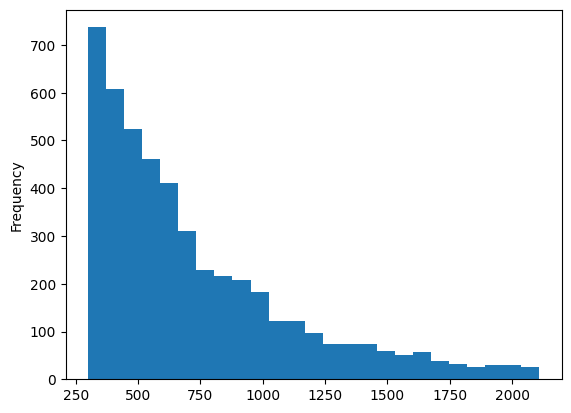

In [29]:
validas_junho['distance(m)'].plot(kind='hist', bins = 25);

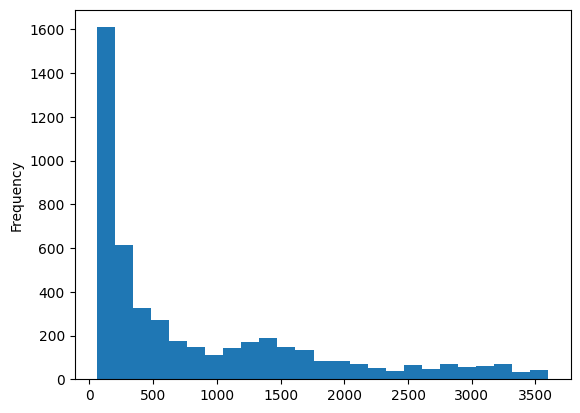

In [30]:
validas_junho['duration(s)'].plot(kind='hist', bins = 25);

In [31]:
# validas_junho.to_excel('viagens_validas_junho.xlsx', engine = 'openpyxl')

In [32]:
validas_junho.loc[((validas_junho['dataFim'] - validas_junho['dataInicio']).dt.total_seconds()  < validas_junho['duration(s)'])]

,index,day,device_id,periodo,dataInicio,dataFim,sequence,distance(m),duration(s),latitudeI,longitudeI,latitudeF,longitudeF
46,46,1,219,Tarde,2021-06-01 16:55:52,2021-06-01 17:03:53,2,1663.685557,485.0,-22.819901,-47.067734,-22.831503,-47.063166
128,128,1,1436,Tarde,2021-06-01 16:54:46,2021-06-01 16:56:54,2,622.427555,144.0,-22.817006,-47.066171,-22.821014,-47.067003
129,129,1,1436,Tarde,2021-06-01 16:54:46,2021-06-01 16:56:54,2,622.427555,144.0,-22.817006,-47.066171,-22.821014,-47.067993
163,163,1,3377,Tarde,2021-06-01 16:55:57,2021-06-01 17:07:13,2,363.667171,704.0,-22.820093,-47.068095,-22.821291,-47.067707
166,166,1,3471,Tarde,2021-06-01 17:02:20,2021-06-01 17:03:42,2,833.461362,85.0,-22.825866,-47.067298,-22.831111,-47.063831
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4026,4026,24,1619,Manha,2021-06-24 11:10:32,2021-06-24 11:18:30,2,323.119766,514.0,-22.824653,-47.065070,-22.825326,-47.066509
4078,4078,24,6975,Manha,2021-06-24 12:35:21,2021-06-24 12:58:08,2,324.157657,1421.0,-22.826055,-47.067018,-22.824980,-47.065703
4143,4143,24,40153,Manha,2021-06-24 11:04:12,2021-06-24 11:22:43,2,1993.838342,1245.0,-22.816355,-47.072655,-22.814148,-47.064433
4144,4144,24,40153,Manha,2021-06-24 11:04:12,2021-06-24 11:22:43,2,1993.838342,1245.0,-22.816355,-47.072655,-22.813680,-47.064938


In [33]:
validas_junho.device_id.value_counts()

351      37
346      32
368      32
322      29
385      29
         ..
27132     1
26996     1
26974     1
26953     1
75750     1
Name: device_id, Length: 1948, dtype: int64

## validas_junho

In [34]:
validas_junho.groupby(pd.Grouper(key='dataInicio', freq='1h')).agg(   {
                                                                          'sequence':'count'
}    )#.plot(kind='bar');

,sequence
dataInicio,
2021-06-01 06:00:00,2
2021-06-01 07:00:00,37
2021-06-01 08:00:00,0
2021-06-01 09:00:00,12
2021-06-01 10:00:00,0
...,...
2021-06-30 14:00:00,5
2021-06-30 15:00:00,0
2021-06-30 16:00:00,11


## Continuacao

- com os pontos de chegada e saida das viagens validas 
- agrupar os pontos por intervalo de tempo (aqui vai ficar a parametrizacao)
- dai para cara intervalo horario vamos ter uma tabela esparsa de origem destino

    - Serao 2 picos, manha e tarde
    - por dia sao 2 matrizes origem/destino
    - sao, em media, 20 dias por mes
    - potencialmente 60 matrizes
    